In [26]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import os

# pegar o caminho completo do arquivo da base de dados
diretorio_atual = os.getcwd()
caminho_dataset = os.path.join(diretorio_atual, 'datasets', 'parkinsons.data')

# carregar a base de dados e colocar na variável df
df = pd.read_csv(caminho_dataset)

# colocar as outras colunas para prever o y
X = df.drop(['status', 'name', 'APQ', 'D2',
            'Fhi(Hz)', 'Flo(Hz)', 'Fo(Hz)',
             'PPQ', 'RAP', 'spread1', 'spread2'], axis=1).copy()

# colocar a coluna a ser prevista em y
y = df['status'].copy()


# dividir as informações de x e y em treino e teste em uma proporção de (0.75) e (0.25)
#TODO: testar stratify:y
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2)

# criar uma pipeline de processos
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()),
                       ('MinMaxScaler', MinMaxScaler()),
                       ('XGBClassifier', XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=3 
                                                        min_child_weight=1, colsample_bytree=0.5, 
                                                        scale_pos_weight=4))])# gamma=0



pipe.fit(X_treino, y_treino)


Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('MinMaxScaler', MinMaxScaler()),
                ('XGBClassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [27]:
from sklearn.model_selection import cross_val_score

-1 * cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_absolute_error')

array([0.23076923, 0.20512821, 0.15384615, 0.20512821, 0.25641026])

In [28]:
import numpy as np
from sklearn.metrics import mean_squared_error

# fazer uma previsão do modelo a fins de teste
previsao_modelo_principal = pipe.predict(X_teste)

# testar a previsão do modelo
np.sqrt(mean_squared_error(y_teste, previsao_modelo_principal))

0.2773500981126146

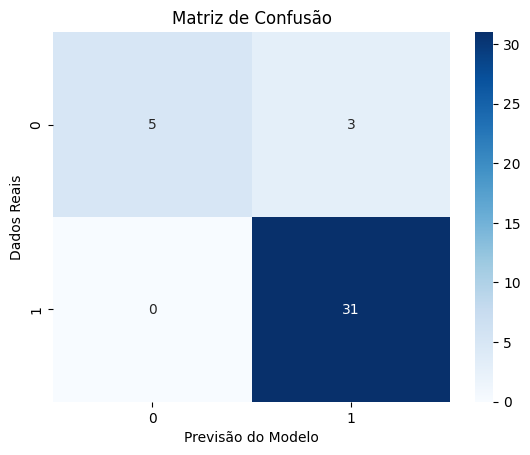

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# criar uma matriz de confusão
matriz_confusao = confusion_matrix(y_teste, previsao_modelo_principal)

# plotar um gráfico com os (TP, FP, TN, FN)
sns.heatmap(matriz_confusao, annot=True, fmt='d',
            cmap='Blues')
plt.xlabel('Previsão do Modelo')
plt.ylabel('Dados Reais')
plt.title('Matriz de Confusão')
plt.show()



In [30]:
# mostra o caminho do arquivo
caminho_dataset_atualizado = os.path.join(
    os.getcwd(), 'datasets', 'parkinsons_updrs.data')

# carregar a nova base de dados
novos_dados = pd.read_csv(caminho_dataset_atualizado)

# criar um df com informações úteis no final mas inúteis para a IA
previsao_final = novos_dados[['subject#', 'age', 'sex', 'test_time']].copy()

# tirar as informações não foram treinadas
novos_dados = novos_dados.drop(
    ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter:PPQ5',
     'Jitter:RAP', 'Shimmer:APQ11'], axis=1)

# calcular as probabilidades da pessoa ter parkinson pegando somente a classe 1 (ter parkinson)
probabilidade_novos_dados = (pipe.predict_proba(novos_dados)[
    :, 1]*100).round(2)

# criando uma coluna de probabilidades de ter parkinson
previsao_final['probabilidade'] = probabilidade_novos_dados

# modelo cataloga como tem ou não parkinson(1 ou 0)
resultado_modelo = pipe.predict(novos_dados)

# criar uma coluna com a previsão do modelo
previsao_final['resultado_modelo'] = resultado_modelo

# salvar o novo df
previsao_final.to_csv('parkinsons_predict.csv', index=False)
